In [1]:
%%time
import os
import math
import scipy
import torch
import pandas as pd
import numpy as np
import matplotlib as plt
import pickle as pkl
import scipy.linalg as LA
import scipy.signal as ss
import warnings
warnings.filterwarnings("ignore")


# from DoAEstimation import *
from models import LSTMModel
from utils import *
from weight import array_weight_vector
from doa import music

repo_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_signal = pd.read_csv(os.path.join(repo_dir,'data','input_signal_sample.csv'))

torch.__version__

CPU times: user 2.52 s, sys: 491 ms, total: 3.01 s
Wall time: 19.1 s


'1.13.1'

### Visualizing the Setup

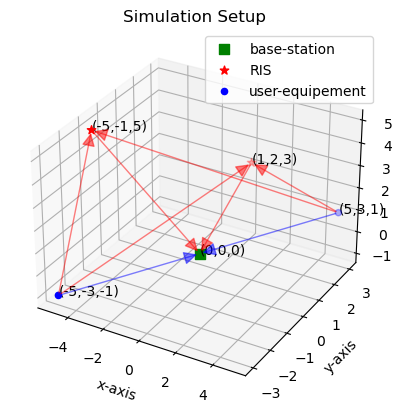

In [2]:
# %matplotlib notebook
show_path = True
coordinates = {
    # equipement: [[xs],[ys],[zs]]
    'bs':[[0],[0],[0]],
    'ris':[[1,-5],[2,-1],[3,5]],
    'ue':[[5,-5],[3,-3],[1,-1]]
}
color = {
    'bs':'g',
    'ris':'r',
    'ue':'b'
}
name = {
    'bs':'base-station',
    'ris':'RIS',
    'ue':'user-equipement'
}

visualize_simulation(coordinates, color, name, show_path=True)

1. 3 user equipements
2. put all user equipements on the XY plane


### Antenna Weight Prediction

In [3]:
lstm = LSTMModel(input_size=5,
                 hidden_size=576,
                 num_layers=4,
                 output_size=128)

state = torch.load(os.path.join(repo_dir,'model_states','model_weights_best_198.pt'), 
                   map_location=torch.device(device))

lstm.load_state_dict(state)
print(lstm.eval())

loc = 70
cols = range(10) # position: [2,3,4,7,8,9] or angle: [0,1,5,6] or position+angle: range(10)

print('\ninput data\n----------')
print(input_signal.iloc[loc,cols])
input_array = input_signal.iloc[loc,cols].values
input_array = np.array(input_array).reshape(1, 2, len(input_array)//2)
input_tensor = torch.tensor(input_array, dtype=torch.float32, device=device)

with torch.no_grad():
    output = lstm(input_tensor)
    
print("\ninput tensor shape:", input_tensor.shape)
print("output tensor shape:", output.shape)

LSTMModel(
  (lstm): LSTM(5, 576, num_layers=4, batch_first=True)
  (linear1): Linear(in_features=576, out_features=288, bias=True)
  (linear2): Linear(in_features=288, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
)

input data
----------
index       25615.000000
polar2         39.243243
azimuth2       78.203795
x2              0.129326
y2              0.619254
z2              0.774467
polar1          0.000000
azimuth1       75.630252
x1              0.000000
y1              0.000000
Name: 70, dtype: float64

input tensor shape: torch.Size([1, 2, 5])
output tensor shape: torch.Size([1, 128])


**Taking limits [0,$\pi$/3] for *polar1* and [0,2$\pi$] for *azimuthal1*.
angle for first signal as `user equipment` signal direction.**

1. path loss model


simulation sample data
----------------------
random signal direction #polar: [53.57160909 19.91878832]
random signal direction #azimuthal: [295.6424843   15.01078526]

base station locations: [0, 0, 0]

RIS 
direction vectors: [[0.006067509241204118, 2.7744162567926823e-05, 0.9999815921115096]]
direction angles: [[19.918788318070632, 15.010785261089966]]
power: [-1.75841946+0.64576634j]

user equipment 
direction vectors: [[0.016251992379168842, 0.0014675892375824373, 0.9998668505983872]]
direction angles: [[53.571609086160095, 295.64248430081943]]
power: [0.15402256-0.63575391j]


<IPython.core.display.Javascript object>


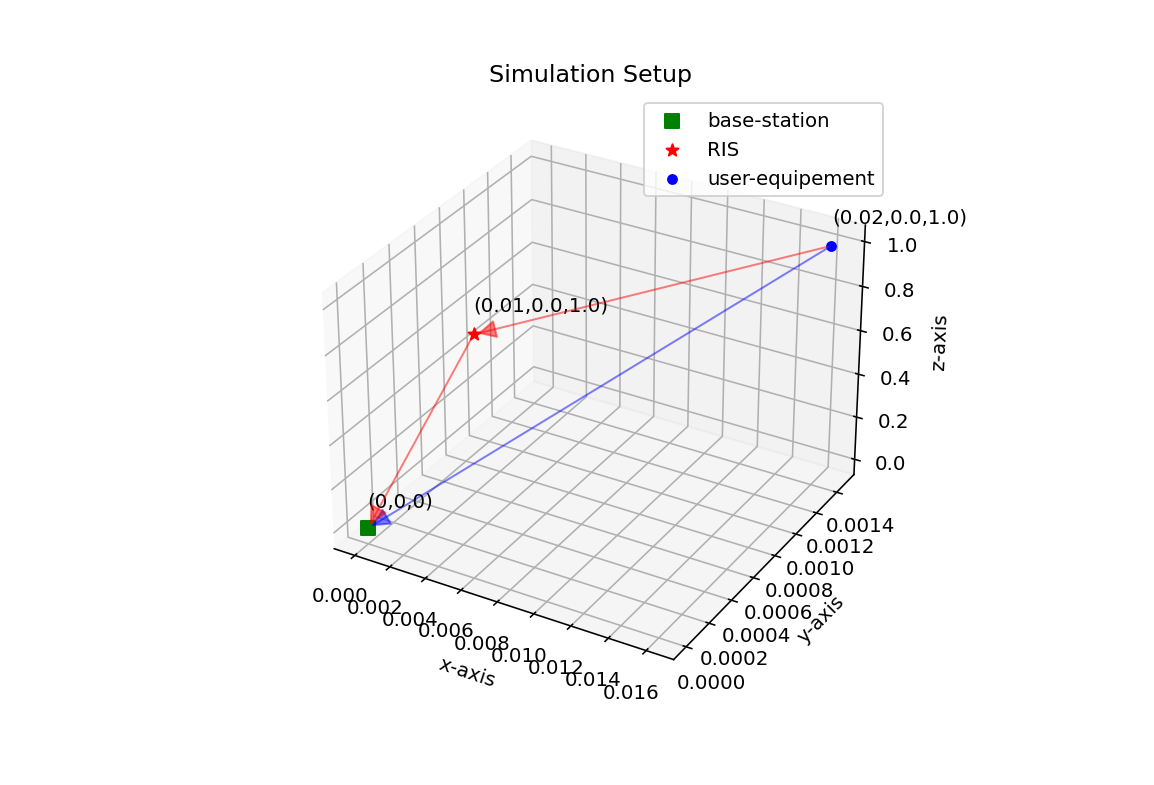

In [4]:
%matplotlib notebook
np.random.seed(6)

P,Q = 8,8 # rows and columns of antenna array
lamda = 1 # wavelength
ue = 1  # number of user equipments
ris = 1  # number of RIS
n_source = ue+ris
n_antenna = P*Q  # number of antenna elements 
snr = 10

print('\nsimulation sample data\n----------------------')
array = np.linspace(0,(n_antenna-1)/2,n_antenna)

# angle for RIS would be added
p_thetas = (np.pi/3)*(np.random.rand(n_source))   # random source polar directions
az_thetas = (2*np.pi)*(np.random.rand(n_source))   # random source azimuthal directions

# p_thetas = input_signal.sample(1,random_state=21)[['polar1','polar2']].values[0]*np.pi/180
# az_thetas = input_signal.sample(1,random_state=21)[['azimuth1','azimuth2']].values[0]*np.pi/180

# power from RIS would be added
ue_alphas = np.sqrt(1/2)*(np.random.randn(ue) + np.random.randn(ue)*1j) # random UE powers
ris_alphas = np.sqrt(1/2)*(np.random.randn(ris) + np.random.randn(ris)*1j) # random RIS powers

print('random signal direction #polar:',p_thetas*180/np.pi)
print('random signal direction #azimuthal:',az_thetas*180/np.pi)

ue_vectors, ris_vectors = [],[]
ue_angles, ris_angles = [], []
for polar,az in zip(p_thetas[:ue],az_thetas[:ue]):
    ue_vectors.append(find_position_vector(polar,az))
    ue_angles.append([polar*180/np.pi,az*180/np.pi])

for polar,az in zip(p_thetas[ue:],az_thetas[ue:]):
    ris_vectors.append(find_position_vector(polar,az))
    ris_angles.append([polar*180/np.pi,az*180/np.pi])

bs_vector = [0,0,0]
print('\nbase station locations:',bs_vector)
print(f'\nRIS \ndirection vectors: {ris_vectors}\ndirection angles: {ris_angles}\npower: {ris_alphas}')
print(f'\nuser equipment \ndirection vectors: {ue_vectors}\ndirection angles: {ue_angles}\npower: {ue_alphas}')

# visualizing the simulation setup
coordinates = {
    'bs':[[0],[0],[0]],
    'ris':np.transpose(ris_vectors).tolist(),
    'ue':np.transpose(ue_vectors).tolist()
}

visualize_simulation(coordinates, color, name, show_path=True, precision=2, anno=True,shift=0.1)

#### In our case study

1. RIS, base station have a fixed position
2. We have to localize the user equipment


In [5]:
numAngles = 360
p_angles = np.linspace(0,np.pi/3,numAngles)*180/np.pi
az_angles = np.linspace(0,2*np.pi,numAngles)*180/np.pi
general_angles = np.array(np.meshgrid(p_angles,az_angles)).T.reshape(-1, 2).tolist()
print('Total sample location collected:', len(general_angles))

Total sample location collected: 129600


### Covariance Matrix

In [6]:
numrealization = 100 # number of time samples collected at antenna array
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = array_weight_vector(ris_vectors,ue_vectors,ris_angles,ue_angles,vector=True,angle=True)

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
#     distortion_ris = np.exp(1j*2*np.pi*np.random.default_rng(seed=21).random(1)) 
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
#     distortion_ue = np.exp(1j*2*np.pi*np.random.default_rng(seed=42).random(1))
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
#     noise = np.sqrt(0.5/snr)                                         \
#         *(np.random.default_rng(seed=6).random(n_antenna)           \
#           +np.random.default_rng(seed=6).random(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)


### Direction Of Arrival

In [27]:
%%time

# MUSIC algorithm
# DoAsMUSIC, psindB = music(CovMat,
#                           n_source,
#                           n_antenna,
#                           angles=general_angles,
#                           ris_data=ris_angles+ris_vectors)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [7]:
file_path = os.path.join(repo_dir,'data','psindB.pkl')
# with open(file_path, 'wb') as file:
#     pkl.dump(psindB, file)
    
with open(file_path, 'rb') as file:
    psindB = pkl.load(file)

<IPython.core.display.Javascript object>


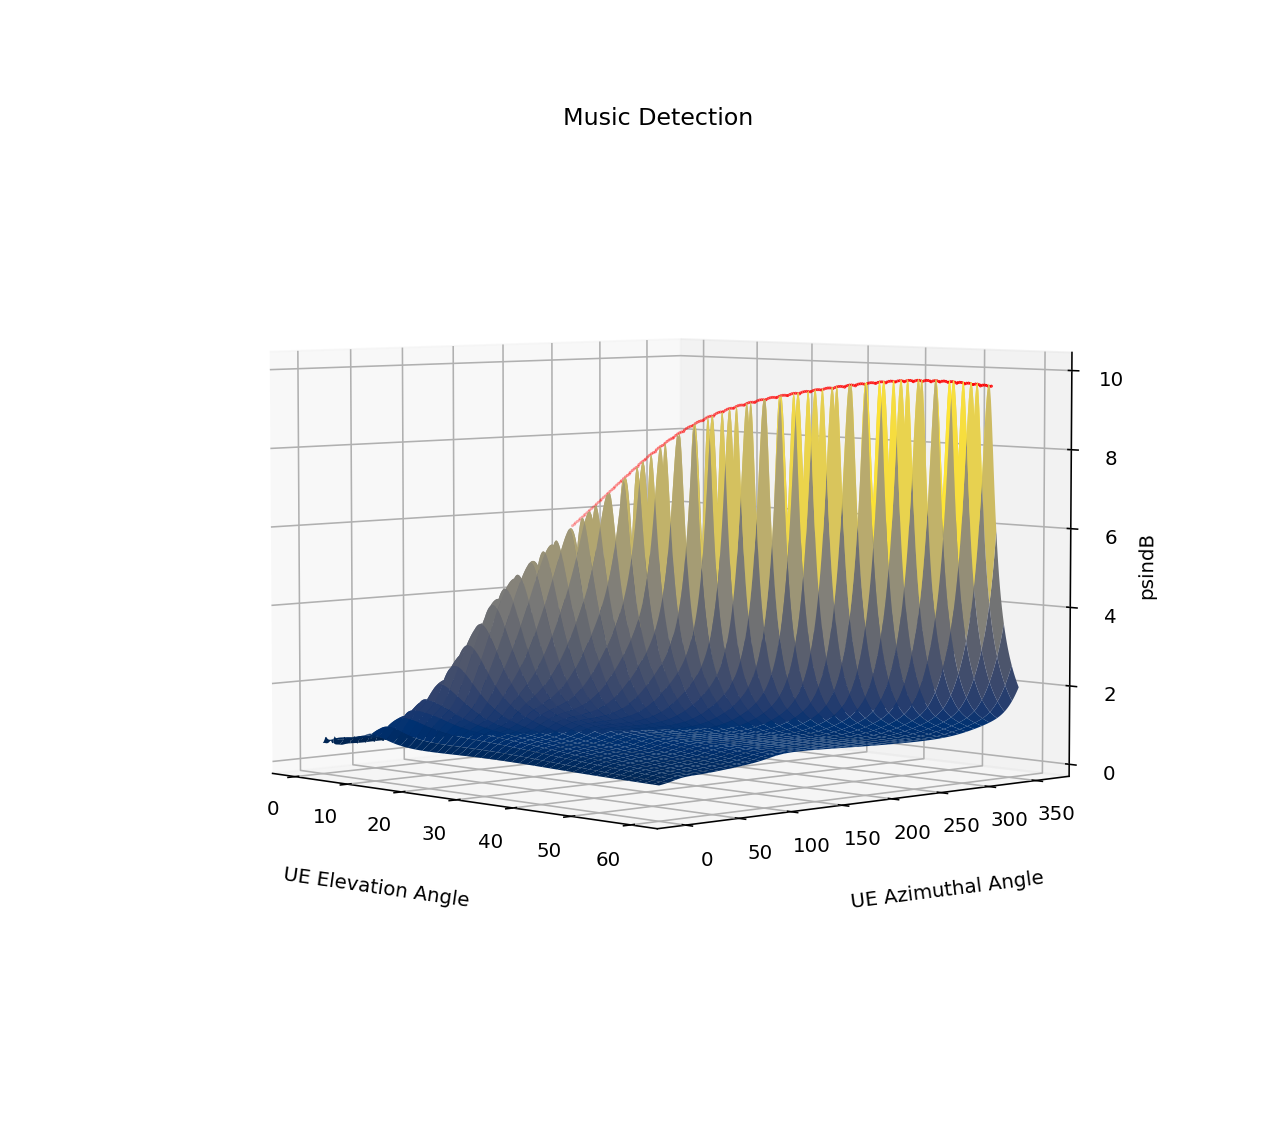

maximum psindB value: 9.771132545929415
peak reached at: [52.98050139275765, 295.8217270194986]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [8]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[6,11], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=20)
ax.set_ylabel('UE Azimuthal Angle', labelpad=20)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

<IPython.core.display.Javascript object>


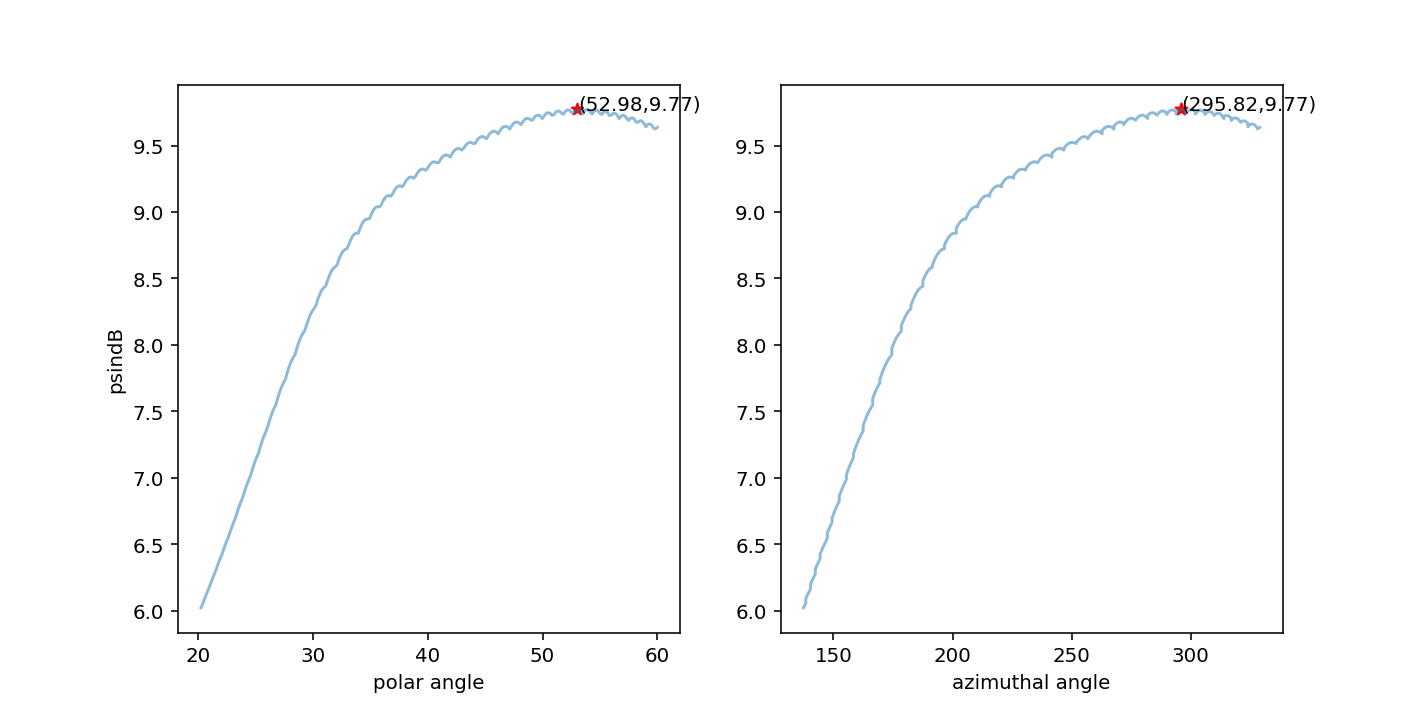

In [9]:
idx = np.argmax(Zs)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(Xs,Zs,alpha=0.5)
plt.scatter(Xs[idx],Zs.max(),marker='*',color='r')
plt.text(Xs[idx]+0.1,Zs.max(),s=f'({round(Xs[idx],2)},{round(Zs.max(),2)})')
plt.xlabel('polar angle')
plt.ylabel('psindB')

plt.subplot(122)
plt.plot(Ys,Zs,alpha=0.5)
plt.scatter(Ys[idx],Zs.max(),marker='*',color='r',s=40)
plt.text(Ys[idx]+0.1,Zs.max(),s=f'({round(Ys[idx],2)},{round(Zs.max(),2)})')
plt.xlabel('azimuthal angle')
# plt.ylabel('psindB')

plt.show()

In [20]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [52.144846796657376, 291.81058495821725]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 10.618771823954537

CPU times: user 764 ms, sys: 27.9 ms, total: 792 ms
Wall time: 494 ms


### Sinusoidal Wave

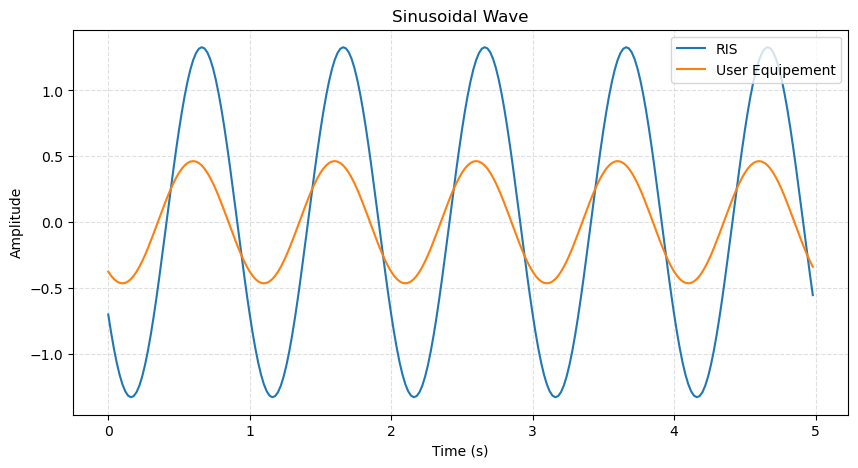

RIS
---
amplitude: 1.3278153880242975
phase: 121.81171352810618

User Equipement
---------------
amplitude: 0.4636784362242461
phase: 143.9470431057731


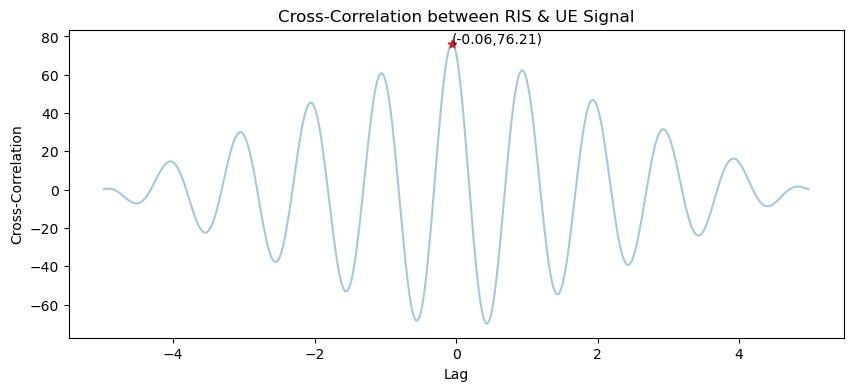


time delay: 0.06 seconds
∇d: 0.06 meters


In [11]:
%matplotlib inline

frequency = 1 #40e9  
duration = 5
sampling_rate=50 # >2*frequency
ue_angle = samples[np.argmax(sinr)].tolist()
specified_vector = find_position_vector(ue_angle[0],ue_angle[1])
ris_data=ris_angles+ris_vectors
weights = array_weight_vector(ris_vectors=[ris_data[1]],
                              ue_vectors=[specified_vector],
                              ris_angles=[ris_data[0]],
                              ue_angles=[ue_angle],
                              vector=True,
                              angle=True
                             )

#ris
distortion_ris = np.exp(1j*2*np.pi*np.random.default_rng(seed=42).random(1)) 
recieved_power_ris = np.sum(distortion_ris*ris_alphas*weights)/n_antenna
ris_time, ris_sinusoidal_wave = complex_to_sinusoidal(recieved_power_ris, 
                                                      frequency, 
                                                      duration,
                                                      sampling_rate=sampling_rate)

#ue
distortion_ue = np.exp(1j*2*np.pi*np.random.default_rng(seed=21+np.argmax(sinr)).random(1))
recieved_power_ue = np.sum(distortion_ue*ue_alphas*weights)/n_antenna
ue_time, ue_sinusoidal_wave = complex_to_sinusoidal(recieved_power_ue, 
                                                    frequency, 
                                                    duration,
                                                    sampling_rate=sampling_rate)

plt.figure(figsize=(10,5))
plt.plot(ris_time, ris_sinusoidal_wave,label='RIS')
plt.plot(ue_time, ue_sinusoidal_wave,label='User Equipement')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sinusoidal Wave')
plt.grid(True, which='major',alpha=0.4,ls='--')
plt.legend()
plt.show()

print('RIS\n---')
print('amplitude:',np.abs(recieved_power_ris))
print('phase:',np.angle(recieved_power_ris)*180/np.pi)

print('\nUser Equipement\n---------------')
print('amplitude:',np.abs(recieved_power_ue))
print('phase:',np.angle(recieved_power_ue)*180/np.pi)

# Calculate cross-correlation
cross_corr_result = cross_correlation(ue_sinusoidal_wave, ris_sinusoidal_wave)

# Plot the cross-correlation result
lags = np.arange(-len(ue_sinusoidal_wave) + 1, len(ris_sinusoidal_wave))/sampling_rate
max_x,max_y = lags[np.argmax(cross_corr_result)], cross_corr_result.max()
plt.figure(figsize=(10, 4))
plt.plot(lags, cross_corr_result, alpha=0.4)
plt.scatter(max_x,max_y, marker="*", color='r')
plt.text(max_x,max_y,s=f'({max_x},{round(max_y,2)})')
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between RIS & UE Signal')
plt.show()

speed=1
time_delay = find_time_delay(ue_sinusoidal_wave, ris_sinusoidal_wave, sampling_rate)
print(f'\ntime delay: {abs(time_delay)} seconds')
print(f'∇d: {abs(time_delay*1)} meters')

### Localizing User Equipements

In [26]:
def ue_location(ue_polar, ue_azimuth, bs_loc, ue_z):
    d2r = np.pi/180
    ue_y = (ue_z-bs_loc[2])*np.tan(ue_polar*d2r)*np.cos(ue_azimuth*d2r)
    ue_x = ue_y*np.tan(ue_azimuth*d2r)+bs_loc[0]
    return [ue_x,ue_y,ue_z]

def del_localization(bs_vector,ue_vector,ris_vector,time_lag,speed=3e8):
#     speed=3e8
#     ue_vector = ue_vectors[0]
#     ris_vector = ris_vectors[0]
    del_ris_ue = np.array(ue_vector)-np.array(ris_vector)
    del_ris_ue = del_ris_ue/np.linalg.norm(del_ris_ue)

    del_bs_ue = np.array(ue_vector)-np.array(bs_vector)
    del_bs_ue = del_bs_ue/np.linalg.norm(del_bs_ue)

    del_loc = (speed/(del_ris_ue-del_bs_ue)*1e-1)*time_delay+0.02
    return del_loc

In [19]:
def SINR(ris_power, ue_power, ris_data, ue_angles, snr=10, return_net_power=False, n_antenna=64):
    powers,sinr = [],[]
    for i,ue_angle in enumerate(ue_angles.tolist()):
        powers.append(power_recieved(ris_power,ue_power,ue_angle,ris_data,ue_seed=i+21).sum()/n_antenna)

    noise = np.sqrt(0.5/snr)                                             \
            *(np.random.default_rng(seed=42).random(n_antenna)           \
              +np.random.default_rng(seed=42).random(n_antenna)*1j).sum()\
               /n_antenna
#     noise = 0
    total_power = np.array(powers).sum()
    for i,power in enumerate(powers):
#         sinr.append(np.abs(power/((total_power-power)+noise)))
        sinr.append(np.abs(power/noise))
    
    if return_net_power:
        return total_power,sinr
    else:
        return sinr

In [27]:
for vectors in ue_vectors:
    ue_vector = ue_location(ue_polar=detected_ue_angles[1],
                            ue_azimuth=detected_ue_angles[0],
                            bs_loc=bs_vector,
                            ue_z=vectors[2]
                           )
    del_loc = del_localization(bs_vector=bs_vector,
                               ue_vector=ue_vector,
                               ris_vector=ris_vectors[0],
                               time_lag=time_delay,
                               speed=1
                              )
    print('position accuracy:',np.average(np.abs(del_loc/np.array(ue_vector))))
# ue_vectors,ue_vector

position accuracy: 0.06793819495149171


## References
1. DoA-Estimation-MUSIC-ESPRIT: https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT/blob/master/DoAEstimation.py